In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Making an SED because that's my job

In [4]:
tphot = 'eg_uma_vizier_phot.vot'
c = 2.998e8*u.m/u.s



votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
wp = []
fp = []
ep = []
print(filters)

filters = ['2MASS:H', '2MASS:J', '2MASS:Ks', 'GALEX:FUV'
 ,'GALEX:NUV', 'Gaia:G', "SDSS:g'" , "SDSS:i'" , "SDSS:r'"
 , "SDSS:u'" , "SDSS:z'" ,'WISE:W1', 'WISE:W2', 'WISE:W3',
 'WISE:W4']

for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) > 0:
        if len(fj1) >1:
            fj_av = np.average(fj1, weights = (1/(e1**2)))
            e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
            e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
        else:
            fj_av, e1_av = fj1[0], e1[0]
        f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
        wp.append(w1.value)
        fp.append(f1.value)
        e1 = ((e1_av*f1)/fj_av).value
        ep.append(e1)

wp, fp, ep = np.array(wp), np.array(fp), np.array(ep)

# plt.figure(figsize=(5, 5))
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')
# plt.xscale('log')
# plt.yscale('log')

[b'2MASS:H' b'2MASS:J' b'2MASS:Ks' b':=3.6um' b':=5.8um' b'GALEX:FUV'
 b'GALEX:NUV' b'Gaia:G' b'Johnson:B' b'Johnson:H' b'Johnson:J'
 b'Johnson:K' b'Johnson:V' b'PAN-STARRS/PS1:y' b'PAN-STARRS/PS1:z'
 b'POSS-II:F' b'POSS-II:J' b'POSS-II:i' b'SDSS:g' b"SDSS:g'" b'SDSS:i'
 b"SDSS:i'" b'SDSS:r' b"SDSS:r'" b'SDSS:u' b"SDSS:u'" b'SDSS:z' b"SDSS:z'"
 b'WISE:W1' b'WISE:W2' b'WISE:W3' b'WISE:W4']


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
cpath = '/media/david/1tb_storage1/emergency_data/eg_uma/hst/cos/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220) 
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]

In [6]:
# path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
path = '/media/david/1tb_storage1/emergency_data/eg_uma/hst/stis/'
x1ds = glob.glob('{}*x1d.fits'.format(path))

data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

In [7]:
data = Table.read('spect.V EG UMa.Gianninas.txt', format='ascii')
# wo, fo = data['wavelength']*u.AA, data['flux']*u.mJy#u.erg/u.s/u.cm**2/u.AA
wo, fo = data['wavelength']*u.AA, data['flux']*u.J/u.s/u.cm**2/u.AA

# plt.plot(wo, fo)

In [8]:
mw, mf = np.loadtxt('scaled_eguma_model.dat', unpack=True)

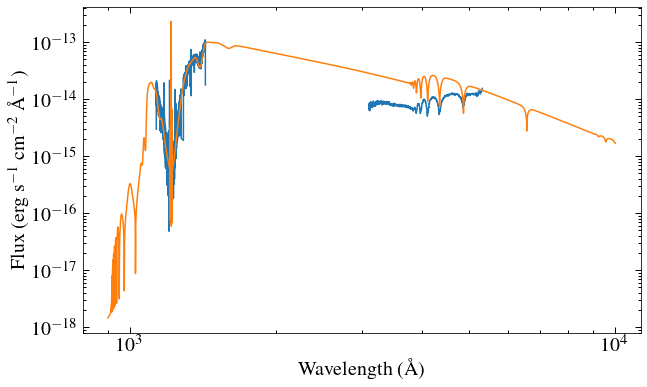

In [9]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
plt.plot(wo, fo*1e11)
plt.plot(mw, mf)

# plt.xlim(1000, 2000)
plt.xscale('log')
plt.yscale('log')

(0.0, 4e-14)

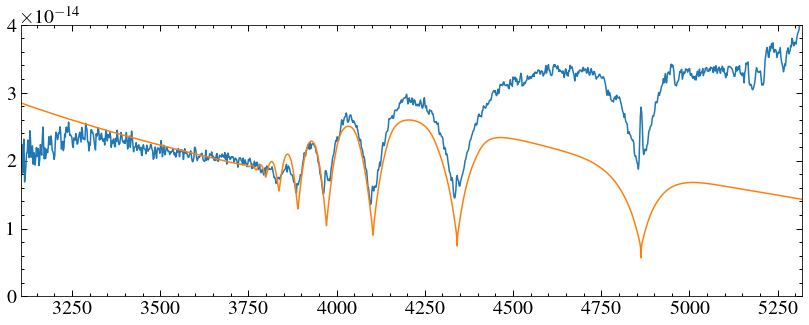

In [10]:
plt.plot(wo, fo*2.7e11)
plt.plot(mw, mf)
plt.xlim(wo[0].value, wo[-1].value)
plt.ylim(0, 0.4e-13)

adding gj1132 to compare

In [11]:
# data = Table.read('/media/david/5tb_storage1/muscles/basic_seds/GJ1132_basic_v1.ecsv')
# gjw, gjf = data['WAVELENGTH'], data['FLUX']

# d_gj = 12.038
# d_eg = 28.71
# gjf = gjf*(d_gj/d_eg)**2
# # plt.plot(gjw, gjf)

In [12]:
# plt.figure(figsize=(10, 6))
# mask = (wc < 1210) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0')
# mask = (wc > 1220) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0', label='COS')
# mask = (ws > 1210) & (ws < 1220) & (fs>0)
# plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # plt.legend(frameon=True)
# # plt.xlim(1140, 1420)
# # plt.ylim(-0.1e-13, 1e-13)

# # plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
# plt.plot(wo, fo*1e11)
# plt.plot(mw, mf)

# plt.plot(gjw, gjf)

# # plt.xlim(1000, 2000)
# plt.xscale('log')
# plt.yscale('log')

Just the UV

In [13]:
# plt.figure(figsize=(10, 6))
# mask = (wc < 1210) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0')
# mask = (wc > 1220) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0', label='COS')
# mask = (ws > 1210) & (ws < 1220) & (fs>0)
# plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # plt.legend(frameon=True)
# # plt.xlim(1140, 1420)
# # plt.ylim(-0.1e-13, 1e-13)

# # plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
# # plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
# # plt.plot(wo, fo*1e11)
# # plt.plot(mw, mf)

# plt.plot(gjw, gjf, c='C2')

# plt.xlim(1100, 1500)

# # plt.xscale('log')
# plt.yscale('log')

Teff of the secondary could be off becasue they didn't have the distance. Urggh, do I need to write a PCEB fitting routine?

Just the UV then. Can I add the COS background spectrum?

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


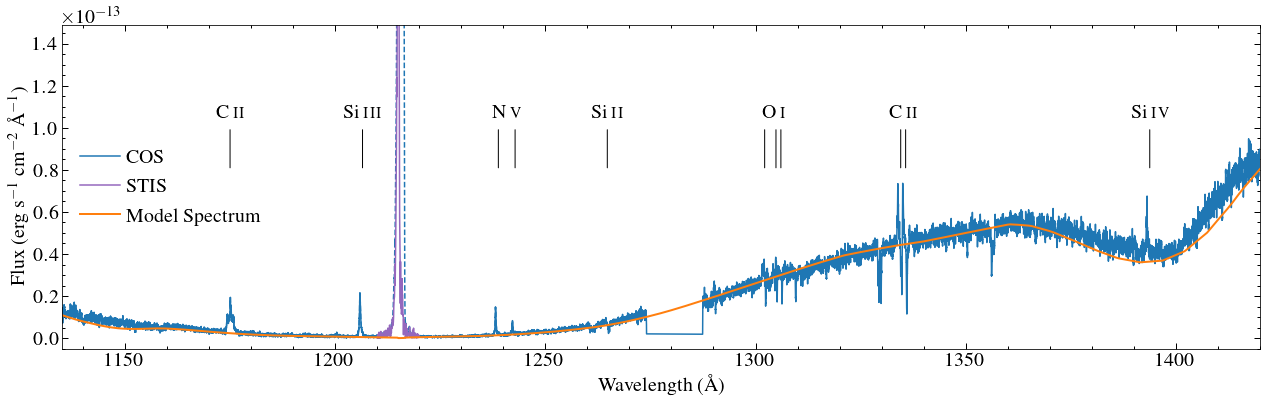

In [14]:
plt.figure(figsize=(18, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C4', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(mw, mf, c='C1', lw=2, label= 'Model Spectrum')

si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775]#,1402.770]
o1 = [1302.17,1304.86,1306.03]
c2 = [1334.532, 1335.703]
c2i = [1175]
si3i = [1206.51]
nv = [1238.821,1242.804]

names = ['Si\,{\sc ii}', 'Si\,{\sc iv}', 'O\,{\sc i}', 'C\,{\sc ii}', 'C\,{\sc ii}', 'Si\,{\sc iii}', 'N\,{\sc v}']
lines = [si2, si4, o1,c2, c2i, si3i, nv]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 0.8e-13), xytext=(line, 1.0e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 1.e-13), xytext=(np.mean(si), 1.05e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

# plt.plot(gjw, gjf, c='C2')

plt.xlim(1135, 1420)
plt.ylim(-0.05e-13, 1.49e-13)
plt.legend(loc=6)

#add background
plt.plot(wc[wc <1250], fc[wc <1250], ls='--', zorder=-10)

plt.tight_layout()
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('plots/eg_uma_fuv.pdf', dpi=150)


Can I fit the CII lines?

[1.171]
-147.3348784536782 km / s 1.4087845120959486 km / s
4.584951439865217 km / s 3.250788837440825 km / s
64.29426704149786 km / s 0.8484360141749114 km / s
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6]
Components: 
    [0]: <Polynomial1D(2, c0=-0., c1=0., c2=-0.)>

    [1]: <Gaussian1D(amplitude=0., mean=1333.8761359, stddev=0.12614168)>

    [2]: <Gaussian1D(amplitude=-0., mean=1334.55241, stddev=0.05848701)>

    [3]: <Gaussian1D(amplitude=-0., mean=1334.81820719, stddev=0.07843254)>

    [4]: <Gaussian1D(amplitude=0., mean=1335.0471359, stddev=0.13124467)>

    [5]: <Gaussian1D(amplitude=-0., mean=1335.72341, stddev=0.03277596)>

    [6]: <Gaussian1D(amplitude=-0., mean=1335.98920719, stddev=0.10592425)>
Parameters:
              c0_0                   c1_0          ...       stddev_6     
    ----------------------- ---------------------- ... -------------------
    -1.1654161620078235e-10 1.7420458189

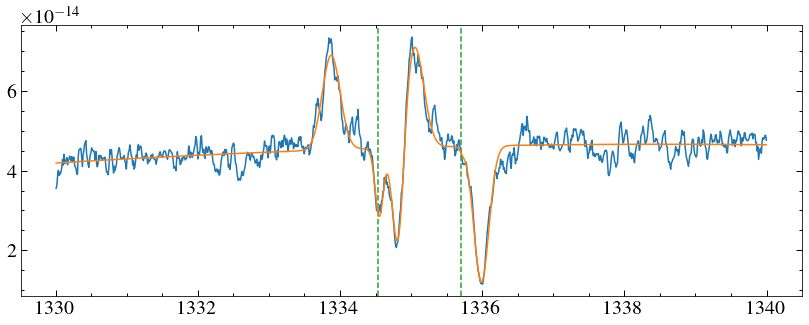

In [15]:
def tiedfunc0(gg_init):
    mean = gg_init.mean_1.value+1.171
    mean = gg_init.mean_1.value+1.171
    return mean

def tiedfunc1(gg_init):
    mean = gg_init.mean_2.value+1.171
    return mean

def tiedfunc2(gg_init):
    mean = gg_init.mean_3.value+1.171
    return mean

fitter = fitting.LevMarLSQFitter()
c2 = [1334.532, 1335.703]
print(np.diff(c2))

cmask = (wc > 1330) & (wc < 1340)
wline, fline, eline, =wc[cmask], fc[cmask], ec[cmask]
plt.plot(wline,fline)

models.Polynomial1D(2)
gg_init = models.Polynomial1D(2)
dv_guess = np.array([-150, -10, +70])*u.km/u.s
stds = [0.1, 0.05, 0.1]
amps =[2e-14, -1e-14, -2e-14]
for line in c2:
    for i, dv in enumerate(dv_guess):
        guess_line = dv.to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
        gg_init += models.Gaussian1D(amps[i], guess_line, stds[i])
gg_init.mean_4.tied=tiedfunc0
gg_init.mean_5.tied=tiedfunc1
gg_init.mean_6.tied=tiedfunc2
gg_fit = fitter(gg_init, wline, fline, weights=1/eline, maxiter=100000)
[plt.axvline(line,ls='--', c='C2') for line in c2]



# dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
dvs = []
dves = []

if type(fitter.fit_info['param_cov']) == np.ndarray:
#     print('hooray!')
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#     print(fit_e)
    epos = [4, 7,10] #index of the mean errors in fit_e
    for i in range(3):
        mean, mean_e = gg_fit[i+1].mean, fit_e[epos[i]]
        dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
        print(dv, dve)
        dvs.append(dv)
        dves.append(dve)



plt.plot(wline, gg_fit(wline))
print(gg_fit)
# plt.show()


In [16]:
m1 = 0.514*u.Msun #Odette's result for the mass of the wd
m2 = 0.24*u.Msun #from Bleach et al 2000
v1 = dvs[2] #wd velocity
v2 = dvs[0] # rd velocity
e1 = dves[2]
e2 = dves[0]
print(e1, e2)
ve = abs(v1/v2)*((e1/v1)**2+(e2/v2)**2)**0.5
print('v1/v2', abs(v1/v2), ve)
# print('ve', ve)
print('m2/m1', m2/m1)

gamma = -29*u.km/u.s
ge = 4.8*u.km/u.s
gs = 22.7*u.km/u.s
ratio_adj = -1*((v1-gamma-gs)/(v2-gamma))
re = ratio_adj*((e1/v1)**2+(e2/v2)**2+(ge/gamma)**2)**0.5
print('v1/v2_adj', ratio_adj, re)

v1b = 81.7 #bleach
v1be = 6.6
v2b = 125.9
v2be= 0.4
vbe = abs(v1b/v2b)*((v1be/v1b)**2+(v2be/v2b)**2)**0.5
print('v1b/v2b', abs(v1b/v2b), vbe)

0.8484360141749114 km / s 1.4087845120959486 km / s
v1/v2 0.4363818514413195 0.00711136142906147
m2/m1 0.46692607003891046
v1/v2_adj 0.5965634812320508 0.09921896864481984
v1b/v2b 0.6489277204130262 0.05246308464856771


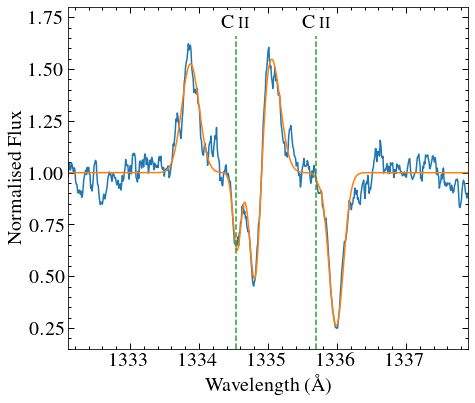

In [17]:
plt.figure(figsize=(7, 6))
plt.plot(wline,fline/gg_fit[0](wline))
plt.plot(wline, gg_fit(wline)/gg_fit[0](wline))
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
plt.xlim(1332.1, 1337.9)
plt.ylim(0.15, 1.8)
for line in c2:
    plt.annotate('C\,{\sc ii}',(line, 1.7), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
    plt.axvline(line, ls='--', c='C2')
plt.tight_layout()
plt.savefig('plots/c2_fit.pdf', dpi=150)

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


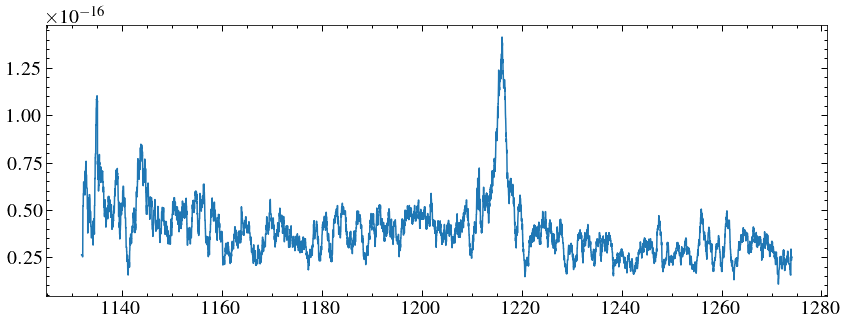

In [18]:
data = fits.getdata(x, 1)[1]
# plt.plot(data['WAVELENGTH'], data['GROSS']- (data['NET']+data['BACKGROUND']))
# plt.plot(data['WAVELENGTH'], data['NET']+data['BACKGROUND'])
# plt.plot(data['WAVELENGTH'], data['NET'])
# plt.plot(data['WAVELENGTH'], data['BACKGROUND'])
conv = data['FLUX']/data['NET']
# plt.plot(data['WAVELENGTH'], data['FLUX']/data['NET'])
# plt.plot(data['WAVELENGTH'], data['FLUX'])
plt.plot(data['WAVELENGTH'], data['BACKGROUND']*conv)

Make plot comparing FUV with Galex pass band. Not very helpful, need more FUV.

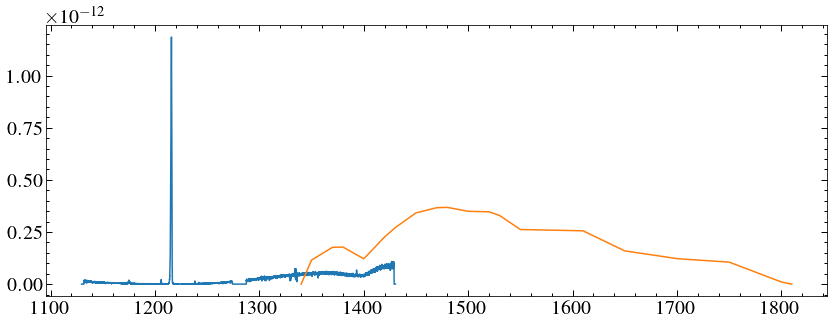

In [19]:
plt.plot(wc, fc)
gbw, gbp = np.loadtxt('/home/david/work/filters/galex/GALEX_GALEX.FUV.dat', unpack=True)
plt.plot(gbw, gbp*1e-12)

20211201 apparently we have a Swift spectrum?

In [20]:
ws, fs, es, dq = np.loadtxt('/media/david/1tb_storage1/emergency_data/eg_uma/swift/uvot/eguma_swift_grism.txt', unpack=True)

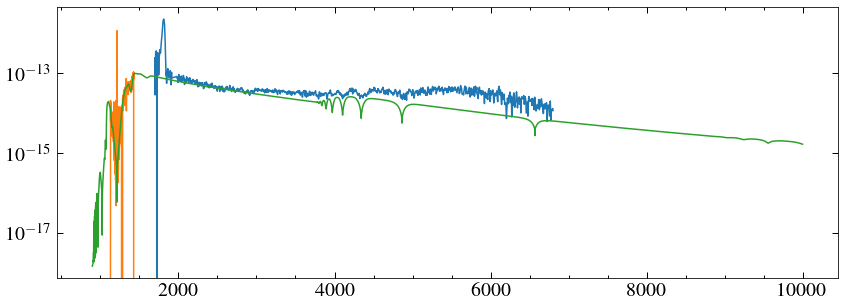

In [21]:
# plt.plot(ws, fs)
mask = (ws > 1700) & (dq == 0)
plt.plot(ws[mask], fs[mask])
plt.yscale('log')
plt.plot(wc, fc)
plt.plot(mw, mf)

Continum is beleaveable but I don't know what that feature at 1800 is. Ok theres a massive flag there, need to use the fits file. Nope not there, huh?

(0.0, 1e-13)

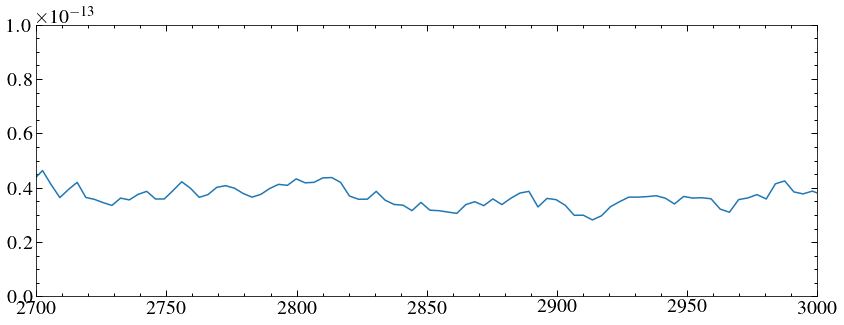

In [22]:
#no mg lines - wd too bright?

plt.plot(ws[mask], fs[mask])
plt.xlim(2700, 3000)
plt.ylim(0, 1e-13)


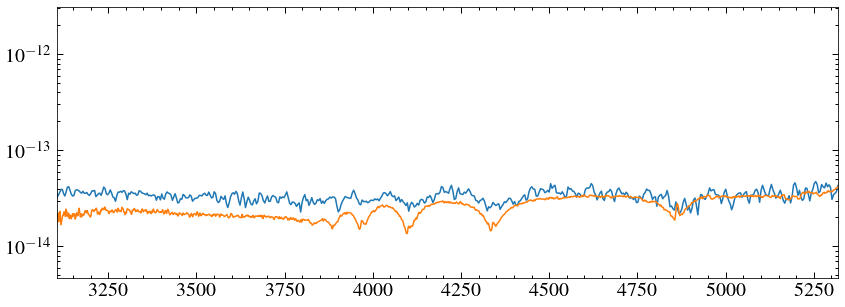

In [31]:
plt.plot(ws[mask], fs[mask])
plt.plot(wo, fo*2.7e11)
plt.xlim(wo[0].value, wo[-1].value)
# plt.ylim(0, 1e-13)
plt.yscale('log')

#low res?